# Capstone Project - Smart Basket for Automatic Product Classification and Counting


___




**Problem Statement:**

In supermarkets and grocery stores, the process of identifying and counting products often requires manual input, which can be slow and prone to errors. This inefficiency can lead to longer checkout times and inaccurate pricing, which negatively impacts both customer experience and store operations. Developing a "smart basket" that automatically recognizes products based on images can significantly speed up the shopping process.

**Context:**

As the retail industry increasingly moves towards automation and efficiency, there is a growing need for smart solutions that can streamline the shopping experience. A smart basket that uses image processing to identify and count products can reduce the need for manual scanning and entry, making the checkout process faster and more accurate. This project aims to bridge this gap by leveraging image processing techniques to develop a model capable of classifying and counting products in real-time.

**Data Sources:**

Primary Dataset: Fruits-360 dataset https://www.kaggle.com/moltean/fruits containing over 70,000 images of 120 types of fruits and vegetables. This dataset will be used to train and validate the image classification model.



## 1 Data Loading and Inspection

Download the necessary libraries for working with archives, file system and data analysis

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [51]:
%matplotlib inline

In [70]:
# Second notebook
try:
    # We use the global variable from the first notepad
    global my_global_df_train
    print("The global variable my_global_df_train is available in the second notebook.")
    
    # Checking the content
    print(my_global_df_train)
    
except NameError:
    print("The global variable my_global_df_train was not found.")


The global variable my_global_df_train is available in the second notebook.
                     label                            processed_image_resized
0              apple_red_3  [[[255,255,255],\n  [255,255,255],\n  [255,255...
1           apple_golden_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
2           apple_rotten_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
3              apple_red_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
4           apple_golden_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
...                    ...                                                ...
9340        apple_golden_3  [[[255,255,255],\n  [255,255,255],\n  [255,255...
9341  apple_granny_smith_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
9342           apple_red_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
9343    apple_red_yellow_1  [[[255,255,255],\n  [255,255,255],\n  [255,255...
9344        apple_rotten_1  [[[255,255,255],\n  [255,255,255],\n  

TypeError: Image data of dtype <U629 cannot be converted to float

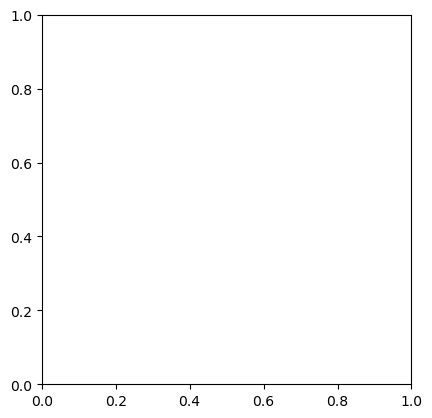

In [59]:
plt.imshow(X_train[0], cmap='gray')

In [46]:
df_train.head()

,label,processed_image_resized
0,apple_red_yellow_1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,pear_1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,cucumber_3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,cucumber_1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,pear_3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [32]:
# Преобразуем строки обратно в массивы NumPy
df_train['processed_image_resized'] = df_train['processed_image_resized'].apply(lambda x: np.array(ast.literal_eval(x)))
df_test['processed_image_resized'] = df_test['processed_image_resized'].apply(lambda x: np.array(ast.literal_eval(x)))

# Теперь массивы можно использовать для обучения моделей

KeyboardInterrupt: 

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9345 entries, 0 to 9344
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    9345 non-null   object 
 1   image_path               9345 non-null   object 
 2   brightness               9345 non-null   float64
 3   processed_image          9345 non-null   object 
 4   image_size               9345 non-null   object 
 5   processed_image_resized  9345 non-null   object 
 6   image_size_resized       9345 non-null   object 
dtypes: float64(1), object(6)
memory usage: 511.2+ KB


In [26]:
# Преобразуем данные изображений в NumPy массивы
x_train = np.stack(df_train['processed_image_resized'].values).astype('float32') / 255.0
x_test = np.stack(df_test['processed_image_resized'].values).astype('float32') / 255.0

ValueError: could not convert string to float: '[[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 245, 0, 0, 167, 245, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 231, 227, 227, 227, 227, 227, 227, 227, 227, 255, 255, 255, 255, 255, 255, 227, 227, 227, 227, 78, 0, 0, 227, 227, 227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 227, 227, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 46, 0, 0, 0, 46, 46, 255, 255, 97, 217, 255, 255, 255, 255, 255, 255, 0, 229, 255, 255, 255, 64, 128, 46, 82, 255, 255, 141, 46, 0, 0, 0, 0, 0, 209, 247, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 191, 0, 0, 0, 64, 64, 255, 255, 255, 255, 5, 0, 206, 227, 64, 64, 64, 0, 0, 255, 0, 110, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 190, 255, 255, 255, 255, 0, 0, 0, 191, 235, 255, 255, 255, 0, 0, 27, 226, 255, 255, 255, 64, 0, 0, 0, 0, 0, 233, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 82, 255, 255, 255, 255, 255, 255, 255, 255, 20, 255, 255, 255, 255, 255, 255, 54, 0, 255, 255, 156, 42, 255, 255, 255, 255, 255, 255, 255, 255, 44, 255, 255, 255, 255, 147, 0, 255, 255, 255, 255, 0, 255, 255, 209, 0, 0, 87, 247, 255, 129, 0, 0, 0, 255, 255, 255, 255, 254, 0, 0, 0, 0, 11, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 196, 0, 0, 255, 155, 255, 255, 255, 255, 255, 255, 255, 255, 0, 51, 255, 255, 255, 255, 217, 0, 130, 255, 253, 255, 255, 255, 255, 255, 207, 0, 109, 0, 255, 255, 249, 255, 0, 127, 108, 255, 255, 255, 233, 0, 255, 255, 255, 255, 255, 91, 0, 0, 0, 255, 255, 255, 0, 57, 255, 255, 255, 255, 255, 127, 0, 0, 0, 0, 243, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 137, 0, 0, 174, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 157, 0, 255, 255, 255, 255, 255, 152, 255, 255, 183, 255, 0, 0, 255, 255, 255, 0, 255, 255, 255, 255, 102, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 137, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 28, 0, 0, 135, 255, 255, 255, 255, 126, 255, 255, 255, 255, 255, 61, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 213, 0, 255, 255, 136, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 195, 0, 255, 255, 255, 255, 255, 255, 161, 0, 201, 255, 255, 135, 33, 0, 8, 255, 17, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 102, 0, 0, 27, 0, 255, 255, 0, 255, 190, 255, 255, 255, 255, 255, 245, 0, 255, 255, 255, 0, 0, 255, 255, 255, 82, 0, 0, 0, 0, 0, 0, 0, 0, 91, 147, 255, 255, 255, 255, 255, 178, 0, 59, 255, 41, 255, 255, 255, 255, 141, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 236, 0, 102, 255, 255, 255, 255, 0, 48, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 39, 0, 0, 171, 255, 255, 255, 151, 0, 0, 255, 255, 255, 255, 84, 202, 238, 87, 255, 255, 255, 0, 255, 255, 255, 255, 205, 0, 255, 255, 255, 0, 0, 171, 171, 171, 0, 0, 104, 164, 255, 255, 255, 255, 0, 253, 0, 0, 121, 255, 255, 255, 24, 0, 255, 255, 255, 255, 255, 124, 231, 0, 255, 255, 255, 255, 255, 0, 35, 255, 255, 255, 160, 0, 74, 255, 52, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 66, 0, 255, 255, 255, 255, 66, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 201, 53, 155, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 189, 255, 255, 255, 255, 255, 0, 0, 203, 255, 73, 255, 255, 139, 194, 255, 255, 195, 0, 255, 255, 0, 255, 255, 214, 255, 102, 254, 0, 211, 255, 255, 255, 0, 0, 255, 255, 0, 34, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 14, 0, 207, 0, 92, 255, 255, 255, 0, 255, 255, 255, 17, 0, 0, 0, 255, 207, 0, 153, 0, 116, 255, 255, 255, 255, 255, 255, 216, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 182, 48, 255, 255, 255, 0, 168, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 102, 0, 255, 255, 243, 182, 255, 233, 0, 108, 255, 184, 0, 45, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 163, 255, 255, 6, 0, 0, 223, 255, 193, 9, 32, 255, 255, 17, 0, 32, 255, 255, 255, 117, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 255, 255, 255, 0, 0, 255, 255, 0, 131, 255, 255, 82, 3, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 0, 74, 255, 255, 108, 0, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 118, 228, 255, 255, 255, 255, 255, 8, 0, 55, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 245, 0, 0, 0, 98, 255, 255, 255, 4, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 241, 241, 255, 255, 255, 8, 0, 255, 255, 232, 0, 255, 255, 255, 242, 255, 255, 255, 255, 255, 0, 245, 255, 255, 255, 255, 253, 0, 255, 255, 90, 29, 255, 255, 4, 255, 40, 255, 0, 5, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 163, 0, 46, 255, 255, 4, 209, 255, 255, 255, 255, 255, 255, 0, 255, 255, 231, 255, 255, 41, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 254, 254, 255, 255, 255, 4, 0, 255, 255, 255, 2, 0, 255, 255, 255, 255, 251, 255, 255, 254, 0, 255, 255, 255, 254, 151, 4, 0, 0, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 0, 191, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 215, 0, 0, 255, 255, 255, 255, 234, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 22, 111, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 199, 255, 255, 255, 255, 66, 0, 233, 255, 255, 36, 0, 255, 255, 255, 0, 255, 255, 0, 12, 255, 255, 255, 0, 153, 255, 22, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 244, 255, 215, 0, 255, 255, 255, 255, 255, 255, 255, 255, 229, 215, 255, 226, 195, 0, 26, 126, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 220, 255, 0, 139, 255, 255, 255, 255, 255, 255, 31, 0, 255, 0, 219, 0, 146, 255, 255, 60, 255, 255, 0, 158, 255, 255, 255, 0, 255, 255, 255, 255, 193, 241, 239, 255, 255, 255, 255, 255, 255, 255, 183, 0, 221, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 216, 0, 255, 255, 0, 255, 205, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 30, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 245, 0, 255, 203, 0, 255, 255, 255, 255, 0, 0, 255, 255, 255, 197, 48, 255, 255, 255, 255, 255, 165, 239, 255, 255, 255, 255, 255, 255, 255, 255, 15, 0, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 210, 255, 255, 255, 0, 255, 255, 255, 255, 237, 0, 0, 255, 76, 152, 179, 253, 255, 255, 50, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 245, 0, 255, 255, 0, 255, 255, 255, 255, 0, 36, 255, 255, 161, 0, 255, 255, 255, 255, 0, 193, 165, 239, 120, 255, 255, 179, 255, 255, 255, 255, 255, 0, 145, 255, 255, 255], [255, 255, 255, 255, 255, 189, 0, 7, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 39, 255, 255, 255, 255, 0, 12, 255, 255, 255, 255, 255, 126, 0, 255, 255, 94, 94, 255, 255, 255, 255, 255, 255, 255, 42, 255, 255, 255, 49, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 251, 0, 219, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 196, 0, 255, 255, 255, 255, 211, 0, 165, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255], [255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 195, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 70, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 245, 0, 255, 255, 82, 153, 255, 255, 46, 255, 0, 139, 255, 214, 0, 255, 255, 255, 255, 255, 193, 165, 255, 0, 223, 255, 34, 28, 255, 255, 255, 255, 215, 0, 252, 255, 255], [255, 255, 255, 255, 38, 33, 255, 255, 255, 255, 255, 0, 255, 129, 255, 255, 255, 255, 255, 255, 255, 255, 255, 129, 255, 255, 17, 162, 255, 229, 0, 0, 255, 255, 255, 255, 255, 126, 255, 255, 155, 255, 255, 255, 95, 255, 0, 187, 255, 218, 219, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 56, 255, 121, 0, 237, 255, 0, 0, 255, 255, 0, 255, 219, 0, 255, 161, 0, 255, 255, 255, 255, 255, 95, 0, 255, 135, 0, 255, 78, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255], [255, 255, 255, 255, 0, 175, 255, 255, 255, 255, 74, 225, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 147, 255, 255, 15, 147, 0, 255, 255, 255, 255, 255, 188, 170, 255, 255, 255, 255, 255, 228, 255, 255, 255, 255, 255, 255, 255, 0, 108, 255, 255, 255, 255, 255, 65, 0, 255, 255, 0, 0, 255, 255, 0, 9, 255, 255, 0, 255, 93, 0, 249, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 63, 0, 255, 255], [255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 163, 195, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 9, 255, 255, 255, 255, 255, 255, 255, 34, 19, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 77, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 255, 82, 0, 255, 255, 0, 210, 0, 0, 251, 255, 185, 17, 255, 255, 255, 255, 193, 0, 255, 255, 255, 26, 255, 0, 46, 255, 255, 255, 255, 255, 0, 255, 255], [255, 255, 255, 143, 156, 0, 255, 255, 255, 0, 80, 255, 255, 255, 255, 255, 255, 222, 0, 0, 0, 0, 72, 72, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 100, 255, 255, 255, 255, 255, 255, 255, 255, 234, 202, 255, 255, 183, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 255, 0, 0, 255, 255, 0, 255, 0, 139, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 83, 255, 255, 0, 199, 227, 0, 255, 255, 255, 255, 255, 0, 100, 255], [255, 255, 255, 0, 217, 52, 255, 255, 255, 20, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 201, 201, 201, 192, 0, 0, 255, 80, 0, 0, 251, 255, 255, 255, 255, 255, 255, 255, 255, 255, 53, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 170, 255, 0, 0, 255, 255, 0, 0, 255, 255, 64, 0, 255, 255, 0, 0, 219, 139, 255, 255, 255, 163, 153, 255, 255, 255, 255, 220, 3, 255, 255, 255, 0, 255, 0, 255, 255, 255, 255, 255, 5, 0, 255], [255, 255, 255, 0, 0, 255, 255, 255, 255, 58, 230, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 129, 255, 255, 255, 255, 255, 255, 219, 255, 255, 255, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 27, 30, 240, 255, 0, 0, 255, 255, 0, 0, 219, 255, 82, 0, 255, 255, 0, 185, 255, 239, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 237, 255, 255, 255, 255, 220, 0, 255], [255, 255, 247, 0, 0, 255, 255, 255, 255, 239, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 129, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 76, 255, 255, 255, 255, 255, 0, 44, 255, 255, 153, 0, 255, 255, 0, 0, 255, 255, 243, 0, 255, 255, 249, 0, 255, 255, 255, 255, 255, 255, 94, 255, 255, 255, 255, 165, 254, 245, 255, 255, 255, 255, 115, 0, 255, 255, 255, 255, 255, 0, 255], [255, 255, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 183, 0, 255, 255, 255, 84, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 0, 128, 255, 255, 70, 0, 255, 255, 255, 255, 255, 102, 255, 255, 255, 255, 90, 255, 255, 255, 255, 255, 255, 124, 0, 255, 255, 255, 255, 255, 0, 203], [255, 255, 0, 8, 255, 255, 255, 254, 255, 229, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 87, 46, 255, 255, 255, 0, 41, 255, 255, 153, 0, 255, 255, 245, 0, 219, 255, 255, 0, 128, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2, 255, 255, 255, 90, 15, 255, 255, 255, 255, 255, 255, 0, 255, 255, 237, 255, 255, 0, 0], [255, 255, 0, 255, 255, 255, 255, 33, 144, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 130, 0, 255, 255, 255, 255, 255, 0, 25, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 139, 255, 255, 0, 255, 255, 255, 153, 0, 255, 255, 245, 0, 219, 255, 255, 0, 128, 255, 173, 0, 255, 255, 0, 255, 255, 255, 255, 0, 255, 255, 255, 255, 239, 255, 255, 255, 255, 255, 255, 36, 255, 255, 255, 255, 255, 22, 0], [255, 98, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 126, 255, 255, 255, 255, 54, 54, 255, 201, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 28, 114, 255, 255, 255, 255, 255, 0, 44, 255, 255, 153, 0, 213, 255, 247, 0, 255, 255, 255, 0, 128, 255, 0, 185, 255, 255, 0, 255, 255, 217, 255, 0, 255, 255, 255, 255, 239, 120, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 54], [255, 0, 8, 255, 255, 255, 255, 255, 129, 255, 255, 255, 255, 255, 183, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 0, 175, 255, 218, 0, 255, 255, 255, 255, 255, 98, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 17, 0, 255, 255, 110, 0, 0, 255, 255, 40, 255, 255, 255, 0, 128, 255, 173, 0, 255, 255, 255, 209, 255, 255, 255, 253, 108, 255, 255, 255, 255, 158, 255, 255, 128, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 0, 255, 255, 255, 255, 255, 152, 0, 255, 255, 255, 0, 255, 5, 149, 255, 255, 106, 90, 255, 255, 70, 58, 255, 255, 255, 0, 255, 255, 255, 83, 255, 255, 255, 255, 255, 98, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 245, 255, 255, 255, 255, 171, 255, 255, 0, 217, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 173, 0, 255, 255, 255, 255, 255, 255, 255, 254, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 0, 255, 255, 255, 255, 255, 255, 0, 244, 255, 255, 0, 255, 255, 255, 255, 236, 86, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 204, 255, 255, 159, 255, 255, 255, 255, 255, 255, 255, 0, 85, 255, 108, 0, 0, 215, 255, 255, 219, 255, 255, 255, 182, 255, 173, 0, 255, 255, 255, 255, 255, 255, 153, 255, 0, 122, 255, 255, 255, 255, 161, 74, 255, 255, 255, 147, 255, 255, 255, 255, 255, 255, 255], [228, 0, 255, 73, 0, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 232, 202, 255, 255, 0, 255, 255, 255, 255, 34, 0, 255, 255, 126, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 64, 255, 255, 255, 28, 255, 255, 255, 255, 255, 255, 255, 211, 201, 255, 255, 0, 0, 159, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 37, 255, 255, 255, 0, 255, 255, 255, 129, 255, 255, 255], [201, 0, 247, 192, 38, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 34, 40, 255, 255, 126, 103, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 23, 143, 255, 255, 255, 155, 33, 255, 255, 255, 255, 255, 255, 255, 0, 255, 153, 255, 0, 159, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 36, 255, 255, 255, 255, 255, 0, 255, 255, 0, 147, 255, 255, 255, 255, 0, 255, 255, 255, 8, 255, 255, 255, 255, 255, 255, 255], [201, 0, 162, 255, 38, 255, 255, 255, 174, 255, 255, 45, 0, 137, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 34, 72, 255, 255, 0, 0, 255, 255, 0, 70, 250, 255, 54, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 123, 255, 255, 255, 255, 0, 159, 255, 167, 255, 213, 255, 255, 255, 255, 255, 70, 22, 255, 255, 255, 255, 255, 0, 255, 255, 176, 0, 199, 255, 255, 255, 113, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [0, 0, 255, 255, 38, 255, 255, 72, 126, 255, 255, 255, 255, 255, 255, 255, 255, 14, 255, 255, 151, 0, 255, 255, 255, 255, 10, 0, 255, 229, 0, 255, 255, 255, 0, 255, 8, 255, 255, 255, 255, 178, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 190, 255, 255, 255, 255, 0, 0, 252, 255, 255, 234, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [0, 232, 255, 255, 9, 255, 255, 0, 126, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 151, 209, 255, 22, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 246, 85, 253, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 202, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 122, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 240, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [54, 255, 255, 255, 0, 255, 255, 0, 255, 255, 109, 255, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 234, 255, 255, 255, 255, 255, 255, 255, 255, 0, 26, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 159, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 36, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 0, 255, 255, 18, 255, 255, 255, 255, 221, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 83, 255, 255, 255, 89, 80, 23, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 141, 255, 255, 255, 255, 255, 255, 255, 255, 186, 255, 255, 255, 255, 255, 80, 255, 255, 255, 255, 255, 0, 159, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 241, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 212, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 6, 51, 255, 0, 249, 255, 255, 255, 255, 0, 0, 0, 0, 26, 255, 255, 255, 255, 6, 143, 249, 255, 6, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 253, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 4, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 105, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 0, 217, 255, 80, 254, 0, 255, 255, 255, 255, 249, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 12, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 139, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 4, 255, 255, 255, 255, 255, 255, 255, 0, 2, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 0, 255, 255, 0, 255, 126, 255, 255, 255, 255, 255, 255, 255, 255, 70, 255, 0, 91, 255, 255, 255, 255, 255, 255, 8, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 67, 255, 255, 255, 241, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 82, 255, 255, 255, 255, 255, 255, 255, 120, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 0, 255, 255, 0, 255, 150, 255, 255, 255, 255, 255, 255, 31, 195, 255, 255, 255, 132, 255, 244, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 143, 255, 255, 255, 255, 129, 48, 48, 213, 255, 255, 255, 255, 255, 255, 255, 255, 255, 61, 238, 255, 255, 255, 255, 255, 255, 199, 0, 255, 255, 255, 68, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 121, 16, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 42, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 207, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 201, 255, 255, 255, 255, 255, 212, 16, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 84, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 171, 255, 221, 255, 255, 255, 255, 216, 0, 255, 118, 255, 255, 0, 255, 255, 230, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 199, 0, 255, 255, 36, 22, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 189, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 153, 0, 0, 255, 255, 255, 58, 255, 255, 0, 235, 255, 0, 255, 255, 255, 255, 255, 255, 255, 5, 161, 255, 205, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 120, 0, 255, 255, 36, 255, 255, 255, 255, 255, 255, 255, 255, 153, 255, 255, 255, 131, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 28, 255, 255, 255, 255, 255, 255, 255, 155, 0], [255, 255, 255, 255, 235, 255, 135, 255, 255, 255, 255, 255, 117, 135, 135, 212, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 188, 0, 98, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 8, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 19, 255, 255, 255, 255, 255, 255, 255, 255, 0, 245, 255, 255, 255, 255, 255, 255, 255, 193, 0, 255, 255, 255, 255, 255, 28, 255, 255, 255, 255, 255, 255, 255, 0, 0], [255, 98, 255, 255, 235, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 163, 195, 112, 69, 255, 255, 255, 255, 255, 255, 255, 16, 118, 255, 255, 255, 255, 118, 255, 255, 0, 0, 182, 255, 137, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 134, 255, 0, 255, 255, 255, 255, 255, 255, 96, 0, 159, 255, 255, 0, 68, 255, 255, 255, 255, 255, 185, 101, 0, 250, 255, 255, 255, 255, 255, 255, 255, 255, 165, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 203], [0, 38, 255, 255, 0, 255, 155, 255, 255, 255, 255, 100, 255, 255, 255, 163, 232, 255, 155, 255, 255, 255, 135, 255, 95, 0, 255, 183, 80, 255, 255, 255, 255, 255, 217, 0, 252, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 155, 255, 255, 255, 255, 255, 255, 0, 0, 159, 255, 255, 219, 68, 255, 255, 255, 255, 255, 255, 255, 200, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 203], [0, 0, 255, 255, 185, 255, 255, 255, 255, 255, 255, 49, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 29, 0, 255, 255, 255, 199, 181, 255, 241, 255, 255, 0, 0, 255, 255, 36, 255, 100, 170, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 48, 0, 159, 255, 255, 219, 255, 255, 255, 255, 255, 255, 255, 36, 255, 255, 255, 255, 255, 255, 81, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255], [201, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 197, 0, 12, 255, 0, 255, 255, 255, 32, 0, 255, 255, 255, 84, 255, 255, 255, 255, 255, 255, 255, 255, 207, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 12, 0, 255, 255, 141, 219, 47, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 140, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255], [201, 0, 255, 255, 38, 66, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 19, 0, 131, 0, 0, 0, 255, 255, 255, 255, 255, 255, 103, 251, 255, 255, 7, 112, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 46, 33, 255, 255, 255, 255, 244, 255, 255, 255, 255, 0, 56, 255, 255, 235, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 6, 0, 255], [201, 0, 255, 255, 231, 66, 255, 255, 255, 0, 99, 255, 255, 255, 255, 255, 255, 255, 133, 227, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 7, 34, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 28, 0, 0, 255, 255, 28, 255, 255, 255, 255, 255, 102, 5, 56, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 102, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 6, 0, 255], [201, 0, 247, 255, 255, 0, 255, 255, 255, 246, 0, 255, 255, 118, 255, 255, 255, 255, 255, 255, 10, 0, 58, 255, 255, 142, 0, 0, 178, 255, 255, 255, 7, 255, 36, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 252, 255, 255, 0, 255, 255, 255, 255, 255, 255, 48, 2, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 250, 255, 255, 255, 255, 0, 2, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 100, 255], [255, 0, 239, 255, 255, 0, 255, 255, 255, 255, 0, 255, 255, 4, 0, 255, 255, 255, 255, 0, 0, 211, 255, 255, 255, 122, 0, 255, 85, 0, 122, 0, 255, 255, 45, 255, 255, 255, 255, 8, 100, 255, 255, 255, 255, 255, 255, 0, 255, 0, 255, 255, 251, 239, 90, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255], [255, 0, 1, 126, 255, 19, 0, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 119, 255, 255, 255, 255, 255, 26, 255, 255, 23, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 229, 255, 255, 255, 0, 255, 255, 26, 229, 255, 255, 255, 255, 255, 255, 255, 0, 245, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 110, 0, 255, 255], [255, 125, 7, 211, 255, 255, 44, 255, 0, 255, 255, 255, 255, 255, 255, 239, 245, 173, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 215, 255, 255, 255, 255, 211, 255, 255, 44, 255, 255, 255, 255, 255, 255, 255, 182, 255, 211, 211, 76, 255, 255, 255, 0, 90, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 247, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255], [255, 255, 0, 0, 255, 255, 255, 255, 160, 255, 133, 139, 255, 222, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 193, 104, 0, 62, 62, 255, 255, 255, 255, 209, 0, 143, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 251, 0, 0, 255, 255, 255, 193, 255, 255, 255, 255, 255, 255, 255, 255, 0, 159, 255, 255, 255, 187, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 153, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 249, 255, 255], [255, 255, 0, 0, 217, 255, 255, 255, 255, 255, 0, 58, 255, 255, 255, 255, 255, 255, 80, 255, 0, 0, 255, 29, 0, 255, 255, 255, 255, 255, 255, 255, 255, 125, 0, 178, 255, 255, 192, 0, 224, 255, 155, 255, 255, 255, 0, 0, 236, 255, 198, 0, 43, 255, 255, 255, 255, 255, 255, 255, 255, 0, 159, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 215, 0, 255, 255, 255], [255, 255, 0, 0, 217, 255, 255, 255, 78, 255, 66, 228, 255, 255, 255, 159, 159, 255, 255, 255, 0, 0, 255, 255, 255, 211, 21, 0, 0, 0, 0, 255, 255, 255, 120, 255, 255, 98, 0, 0, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 142, 96, 255, 255, 255, 255, 255, 255, 255, 255, 30, 0, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 18, 255, 255, 215, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255], [255, 255, 0, 0, 217, 255, 84, 0, 0, 243, 255, 82, 255, 255, 0, 0, 0, 46, 255, 255, 198, 230, 255, 141, 0, 0, 99, 0, 0, 114, 255, 255, 255, 255, 255, 255, 255, 168, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 169, 255, 255, 255, 210, 0, 56, 255, 255, 78, 255, 255, 82, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 145, 255, 255, 255], [255, 255, 0, 0, 255, 255, 172, 131, 255, 137, 255, 255, 255, 255, 248, 255, 255, 255, 255, 255, 255, 255, 96, 0, 0, 188, 255, 255, 255, 255, 255, 255, 212, 97, 255, 255, 255, 255, 255, 255, 255, 255, 199, 110, 255, 255, 140, 255, 255, 255, 255, 255, 255, 255, 255, 131, 255, 255, 255, 0, 0, 255, 255, 255, 0, 255, 124, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 76, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 157, 0, 255, 255, 255, 255], [255, 255, 252, 0, 255, 255, 255, 8, 255, 160, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 106, 0, 0, 0, 154, 255, 255, 148, 106, 255, 255, 255, 0, 189, 255, 255, 255, 255, 255, 255, 164, 251, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 219, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 173, 255, 255, 255, 255, 255, 255, 255, 255, 255, 56, 255, 255, 255, 147, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 27, 23, 255, 255, 255, 255], [255, 255, 255, 0, 230, 189, 255, 0, 170, 255, 255, 255, 255, 255, 255, 223, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 22, 0, 115, 255, 255, 255, 226, 255, 255, 167, 167, 201, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 177, 255, 255, 255, 41, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 40, 255, 255, 255, 255], [255, 255, 255, 104, 0, 255, 255, 235, 0, 70, 255, 255, 255, 70, 255, 255, 113, 0, 0, 0, 185, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 251, 255, 255, 255, 255, 255, 0, 150, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 193, 0, 255, 255, 255, 255, 255], [255, 255, 255, 255, 0, 255, 255, 235, 0, 203, 0, 37, 255, 231, 3, 52, 12, 0, 233, 255, 255, 219, 255, 255, 245, 52, 52, 109, 255, 255, 255, 68, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 66, 255, 255, 255, 255, 255, 0, 239, 255, 255, 255, 255, 54, 0, 207, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 117, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 35, 0, 255, 255, 255, 255, 255], [255, 255, 255, 255, 0, 255, 255, 255, 0, 233, 255, 255, 255, 255, 12, 0, 0, 221, 255, 255, 255, 0, 255, 221, 0, 0, 0, 221, 0, 255, 0, 0, 84, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 225, 0, 0, 255, 255, 255, 108, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255], [255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 253, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 253, 0, 224, 255, 255, 255, 255, 255, 144, 194, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 191, 255, 255, 255, 255, 255], [255, 255, 255, 255, 40, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 253, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 18, 255, 255, 255, 255, 253, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2, 82, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 253, 0, 255, 42, 255, 255, 255, 255], [255, 255, 255, 255, 255, 0, 158, 255, 255, 255, 255, 255, 255, 255, 255, 0, 60, 62, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 10, 255, 255, 81, 255, 244, 0, 255, 20, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 244, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 42, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 17, 0, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 232, 255, 217, 255, 255, 255, 255, 255, 255, 217, 255, 255, 255, 255, 255, 255, 38, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 147, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 111, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 189, 0, 255, 255, 255, 255, 239, 229, 255, 255, 255, 255, 255, 255, 0, 104, 255, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 149, 255, 199, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 96, 0, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 0, 187, 255, 255, 255, 204, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 186, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 180, 31, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 84, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 146, 129, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 211, 245, 255, 255, 255, 255, 255, 255, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 107, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 227, 0, 244, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 0, 199, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 129, 255, 255, 255, 255, 255, 255, 255, 255, 117, 155, 255, 255, 255, 255, 255, 255, 133, 227, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 189, 2, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 167, 0, 193, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 0, 229, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 245, 255, 255, 110, 255, 255, 255, 255, 207, 87, 255, 194, 230, 255, 255, 255, 255, 255, 255, 34, 16, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 83, 0, 255, 138, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 31, 255, 255, 255, 255, 255, 255, 255, 255, 46, 255, 255, 255, 0, 255, 255, 255, 255, 207, 153, 255, 255, 255, 255, 255, 255, 255, 255, 208, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 74, 255, 255, 255, 255, 255, 255, 74, 184, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 62, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 218, 255, 255, 255, 255, 255, 255, 255, 255, 207, 153, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 20, 18, 112, 82, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 44, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 7, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 87, 255, 255, 38, 38, 255, 255, 255, 255, 255, 217, 217, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 224, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 41, 255, 255, 255, 255, 255, 255, 255, 153, 0, 74, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 249, 0, 255, 244, 255, 255, 255, 255, 255, 255, 255, 255, 53, 255, 235, 255, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 5, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 103, 16, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 71, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 155, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 165, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 4, 16, 255, 255, 255, 255, 255, 255, 255, 255, 155, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 13, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 225, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 24, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 161, 255, 255, 255, 255, 255, 255, 169, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 144, 0, 255, 255, 255, 255, 255, 255, 214, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 48, 255, 255, 255, 214, 0, 183, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 4, 0, 187, 255, 255, 255, 255, 102, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 217, 225, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 108, 0, 113, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 230, 0, 252, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 169, 239, 255, 255, 255, 255, 255, 255, 0, 123, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 226, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 201, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 3, 191, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 153, 227, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 151, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 153, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 133, 0, 0, 73, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 234, 0, 116, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 195, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 55, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 116, 0, 0, 109, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 198, 0, 40, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 61, 2, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 98, 0, 0, 0, 0, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 148, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 80, 80, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 35, 0, 40, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 62, 0, 0, 0, 0, 193, 145, 0, 4, 255, 255, 18, 255, 255, 255, 255, 255, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 193, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 211, 0, 0, 20, 44, 255, 255, 255, 255, 255, 255, 255, 255, 136, 1, 0, 0, 0, 129, 255, 255, 255, 255, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 0, 211, 211, 211, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 218, 0, 0, 0, 0, 3, 26, 26, 26, 0, 0, 0, 0, 0, 181, 255, 255, 255, 255, 255, 255, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 193, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 247, 0, 0, 0, 0, 0, 0, 0, 0, 247, 255, 255, 255, 255, 255, 255, 255, 255, 250, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]'

Extract Features and Labels from DataFrame

Path to the main data folder. This folder should contain images and metadata

In [84]:
main_dir = os.path.join(extract_path, 'fruits-360')

View the contents of the main folder. Here we should see, for example, a folder with original images and possibly support files

In [85]:
# Viewing the contents of the main folder
print(f"Folder contents '{main_dir}': {os.listdir(main_dir)}")

Folder contents '../data/raw/fruits-360/fruits-360': ['.DS_Store', 'fruits-360-original-size']


Determine the path to the folder with the original images. This folder should contain subdirectories with images organized by category

In [86]:
original_size_dir = os.path.join(main_dir, 'fruits-360-original-size')

In [87]:
# View the contents of the folder
print(f"Folder contents '{original_size_dir}': {os.listdir(original_size_dir)}")

Folder contents '../data/raw/fruits-360/fruits-360/fruits-360-original-size': ['.DS_Store', 'Test', 'Papers', 'Training', 'Meta', 'readme.md', 'Validation']


Determine the paths to folders with training, and test data. These folders contain images divided into categories for **training, testing** and **validation** of models

In [88]:
# Path to the training data folder
train_dir = os.path.join(original_size_dir, 'Training')

# Path to the folder with test data
test_dir = os.path.join(original_size_dir, 'Test')

# Path to the validation data folder
validation_dir = os.path.join(original_size_dir, 'Validation')

Create a function that will return a list of only folders from the specified directory. Check how many images are in one of the folders (classes). For example, select the first class from the list and count the number of images in it. 

In [89]:
# Function for filtering only folders
def list_dirs_only(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Getting a list of folders in the training set
folders = list_dirs_only(train_dir)

# View the first 5 folders after filtering
print(f"Examples of classes (folders) in the training set: {folders[:5]}")

# Checking the number of images in one of the classes
sample_class = folders[0]  # первый класс в списке
sample_images = os.listdir(os.path.join(train_dir, sample_class))
print(f"Number of images in the class '{sample_class}': {len(sample_images)}")


Examples of classes (folders) in the training set: ['cucumber_3', 'zucchini_1', 'apple_red_yellow_1', 'apple_crimson_snow_1', 'pear_1']
Number of images in the class 'cucumber_3': 163


The first thing to do is to **create a DataFrame**, which will contain information about each image in the dataset. This DataFrame will store image file paths and their corresponding classes.

In [90]:
def create_image_dataframe(directory):
    """
    Creates a DataFrame containing information about classes and image paths in the specified directory.

    :param directory: The path to the directory with image folders.
    :return:DataFrame с двумя колонками: 'label' и 'image_path'.
    """
    data = []
    
    # Pass through all folders in the specified directory    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            # Для каждой папки (категории) проходимся по изображениям
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                data.append({'label': category, 'image_path': img_path})
    
    # Convert the list to DataFrame
    df = pd.DataFrame(data)
    
    return df


In [91]:
# Using the function to create a DataFrame for training data
df_train = create_image_dataframe(train_dir)

# Using the function to create a DataFrame for test data
df_test = create_image_dataframe(test_dir)

# Using the function to create a DataFrame for validation data
df_validation = create_image_dataframe(validation_dir)

Checking the first 10 rows for 3 sets to make sure that the data is loaded correctly and contains the necessary information.

In [92]:
# Checking the first few rows for the training set
df_train.head(10)

,label,image_path
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
1,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
3,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
4,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
5,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
6,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
7,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
8,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
9,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...


In [93]:
# Checking the first few lines for the test set
df_test.head(10)

,label,image_path
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
1,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
3,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
4,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
5,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
6,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
7,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
8,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
9,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...


In [94]:
# Checking the first few lines for the validation set
df_validation.head(10)

,label,image_path
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
1,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
3,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
4,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
5,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
6,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
7,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
8,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
9,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...


Let's combime validation and training datasets

In [97]:
# Combining the training and validation DataFrames
df_train = pd.concat([df_train, df_test], ignore_index=True)

# Shuffle the combined DataFrame for better randomness in classification
df_train = df_combined.sample(frac=1).reset_index(drop=True)

# Check the first few rows of the combined dataset
df_train.head()


,label,image_path
0,apple_red_yellow_1,../data/raw/fruits-360/fruits-360/fruits-360-o...
1,pear_1,../data/raw/fruits-360/fruits-360/fruits-360-o...
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...
3,cucumber_1,../data/raw/fruits-360/fruits-360/fruits-360-o...
4,pear_3,../data/raw/fruits-360/fruits-360/fruits-360-o...


In [98]:
# Проверка уникальных меток
print("Unique labels in the combined dataset:")
print(df_train['label'].unique())

Уникальные метки в объединенном датасете:
['apple_red_yellow_1' 'pear_1' 'cucumber_3' 'cucumber_1' 'pear_3'
 'cabbage_white_1' 'apple_golden_1' 'apple_red_3' 'apple_6'
 'apple_red_delicios_1' 'apple_golden_2' 'apple_red_2' 'apple_golden_3'
 'apple_hit_1' 'apple_rotten_1' 'apple_crimson_snow_1' 'zucchini_dark_1'
 'apple_pink_lady_1' 'apple_granny_smith_1' 'eggplant_long_1' 'zucchini_1'
 'carrot_1' 'apple_braeburn_1' 'apple_red_1']


## 2 Checking the distribution of classes

First, let's see how the images are divided into classes. This will help to understand whether the data is balanced or some classes dominate.

In [103]:
def plot_combined_class_distribution(df_train, df_test, class_column='label'):
    """
    Function for building a combined class distribution for training, test and validation data sets on one graph.
    
    :param df_train: DataFrame containing training data
    :param df_test: DataFramE containing test data
    :param df_validation: DataFraMe containing validation data
    :param class_column: Name of the column containing classes (default 'class')
    """
    # Counting the number of images in each class for each data set
    class_distribution_train = df_train[class_column].value_counts()
    class_distribution_test = df_test[class_column].value_counts()
    class_distribution_validation = df_validation[class_column].value_counts()
    
    # Creating a common DataFrame for all distributions
    combined_df = pd.DataFrame({
        'Training': class_distribution_train,
        'Test': class_distribution_test,
    }).fillna(0)  # Filling missing values with zeros
    
    # Building a class distribution histogram for all sets
    combined_df.plot(kind='bar', figsize=(20, 10))
    plt.title('Combined Class Distribution for Training and Test Sets')
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)  # Rotate labels on the X axis for easy reading
    plt.show()


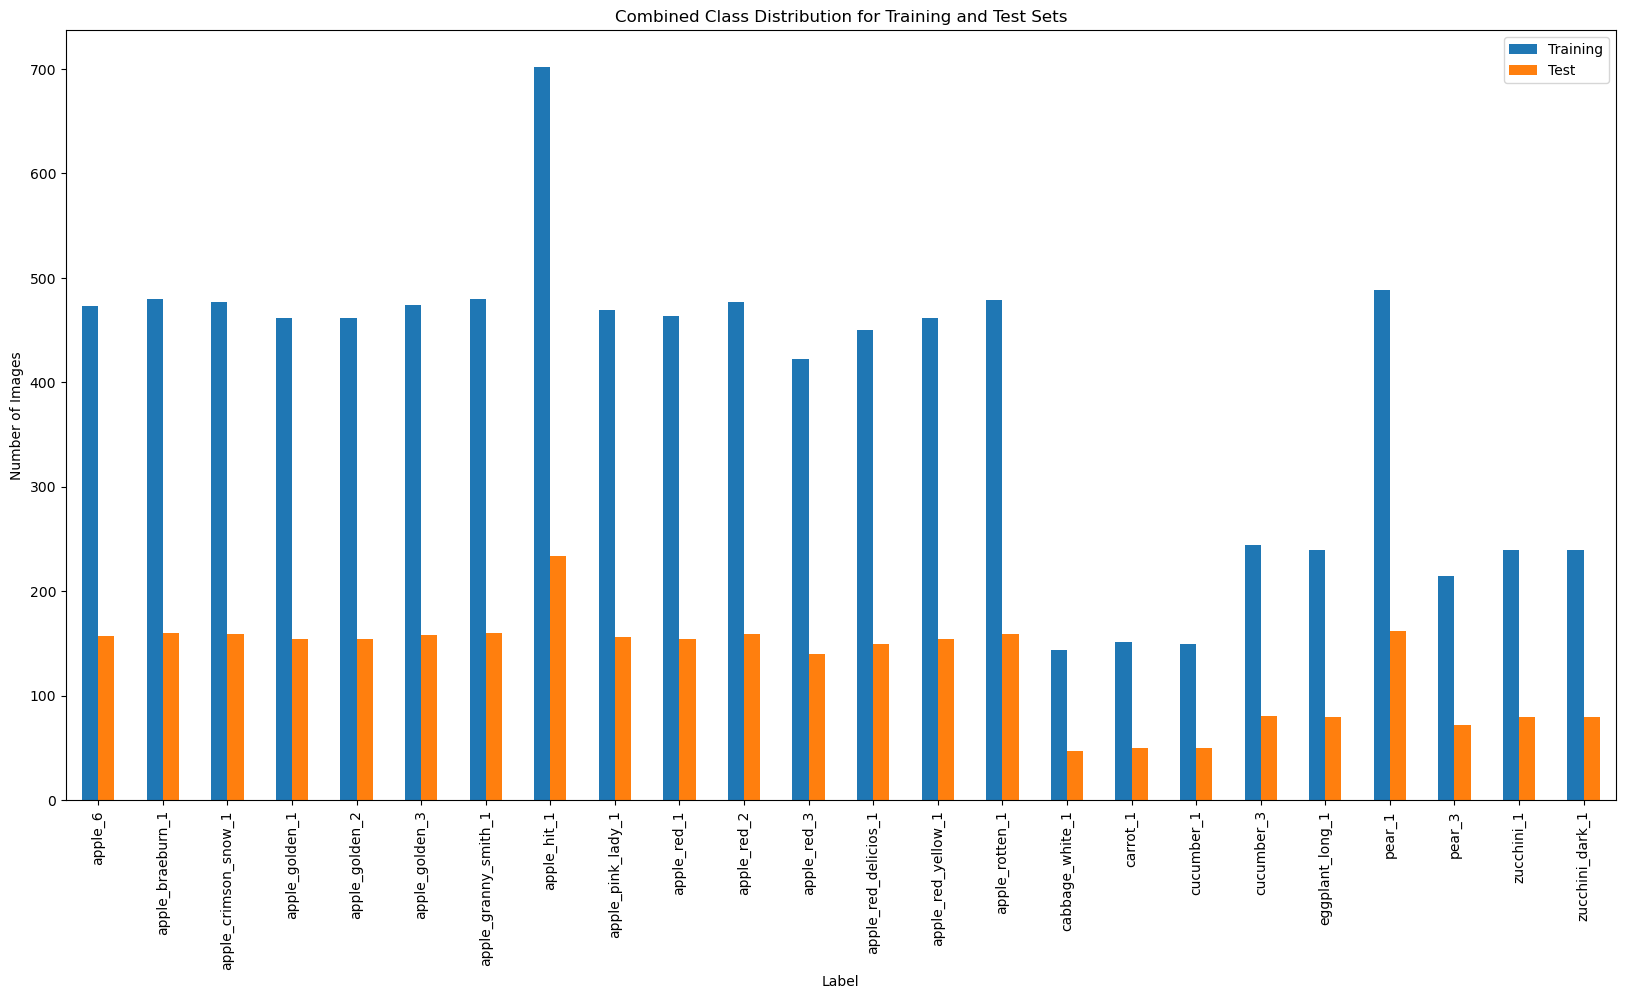

In [104]:
# Applying the function to three data sets
plot_combined_class_distribution(df_train, df_test)

The graph shows the distribution of the number of images for each class in the training and test data sets.

- You can see that for most classes, the number of images in the training data set (indicated in blue) significantly exceeds the number of images in the test data set (orange). This is expected, as more data in the training set is required for effective training of the model.
- The number of images for each class in the test data set is approximately consistent across different classes. This consistency helps ensure an objective assessment of the model on data that was not used in training.
- Some classes, such as "apple_hit_1" and "apple_granny_smith_1," have much more images in the training set compared to other classes, such as "cabbage_white_1" and "carrot_1." This may indicate an imbalance in class data, which should be taken into account when training the model to avoid overfitting on more represented classes.

This distribution is important for understanding how well the data is structured and balanced for classification tasks.

## 3 Analysis of image brightness by class

At this stage, the average brightness of the image is calculated and a graph of the brightness distribution by classes is built.

In [111]:
def plot_brightness_distribution(df, title='Brightness distribution by class'):
    """
    Function for calculating the brightness of images and building a histogram of brightness distribution by class.
    
    :param df: DataFrame containing data.
    :param title: Title for the chart (default 'Brightness distribution by class').
    """
    # Applying the function to all images
    df['brightness'] = df['image_path'].apply(lambda x: calculate_brightness(cv2.imread(x, cv2.IMREAD_GRAYSCALE)))
    
    # Construction of brightness distribution by class
    plt.figure(figsize=(20, 12))
    for class_name in df['label'].unique():
        brightness_values = df[df['label'] == class_name]['brightness']
        plt.hist(brightness_values, bins=50, alpha=0.5, label=class_name)
    
    plt.title(title)
    plt.xlabel('Brightness')
    plt.ylabel('Number of images')
    plt.legend()
    plt.show()


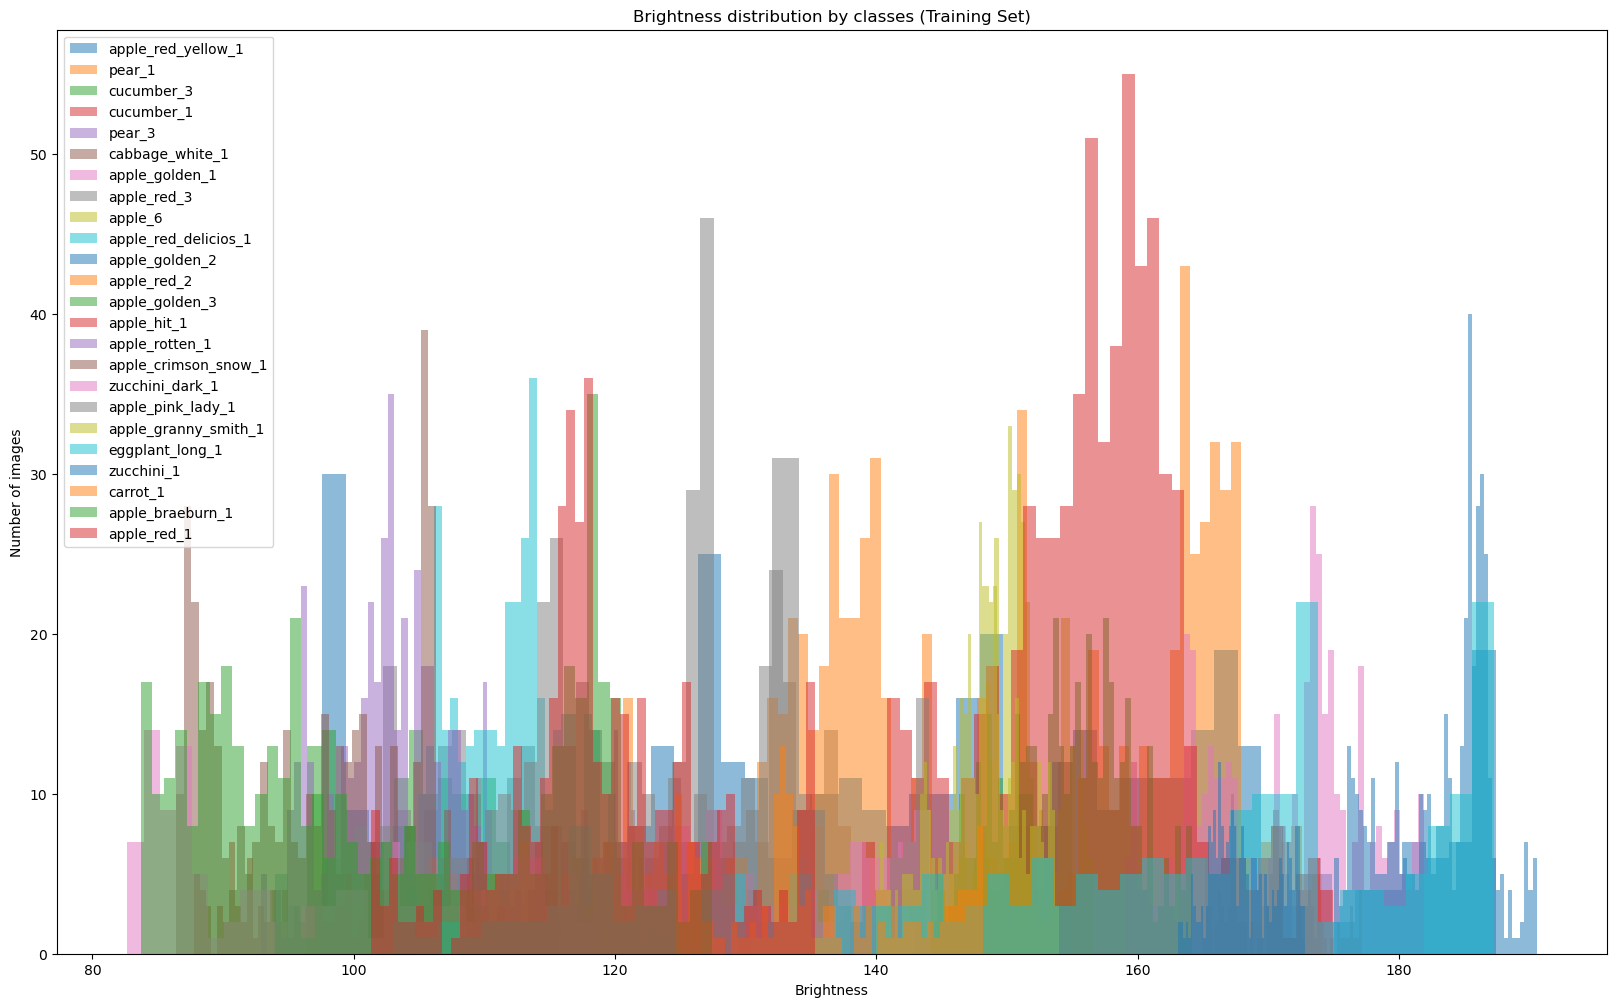

In [112]:
# Example of using a function for a training set
plot_brightness_distribution(df_train, title='Brightness distribution by classes (Training Set)')

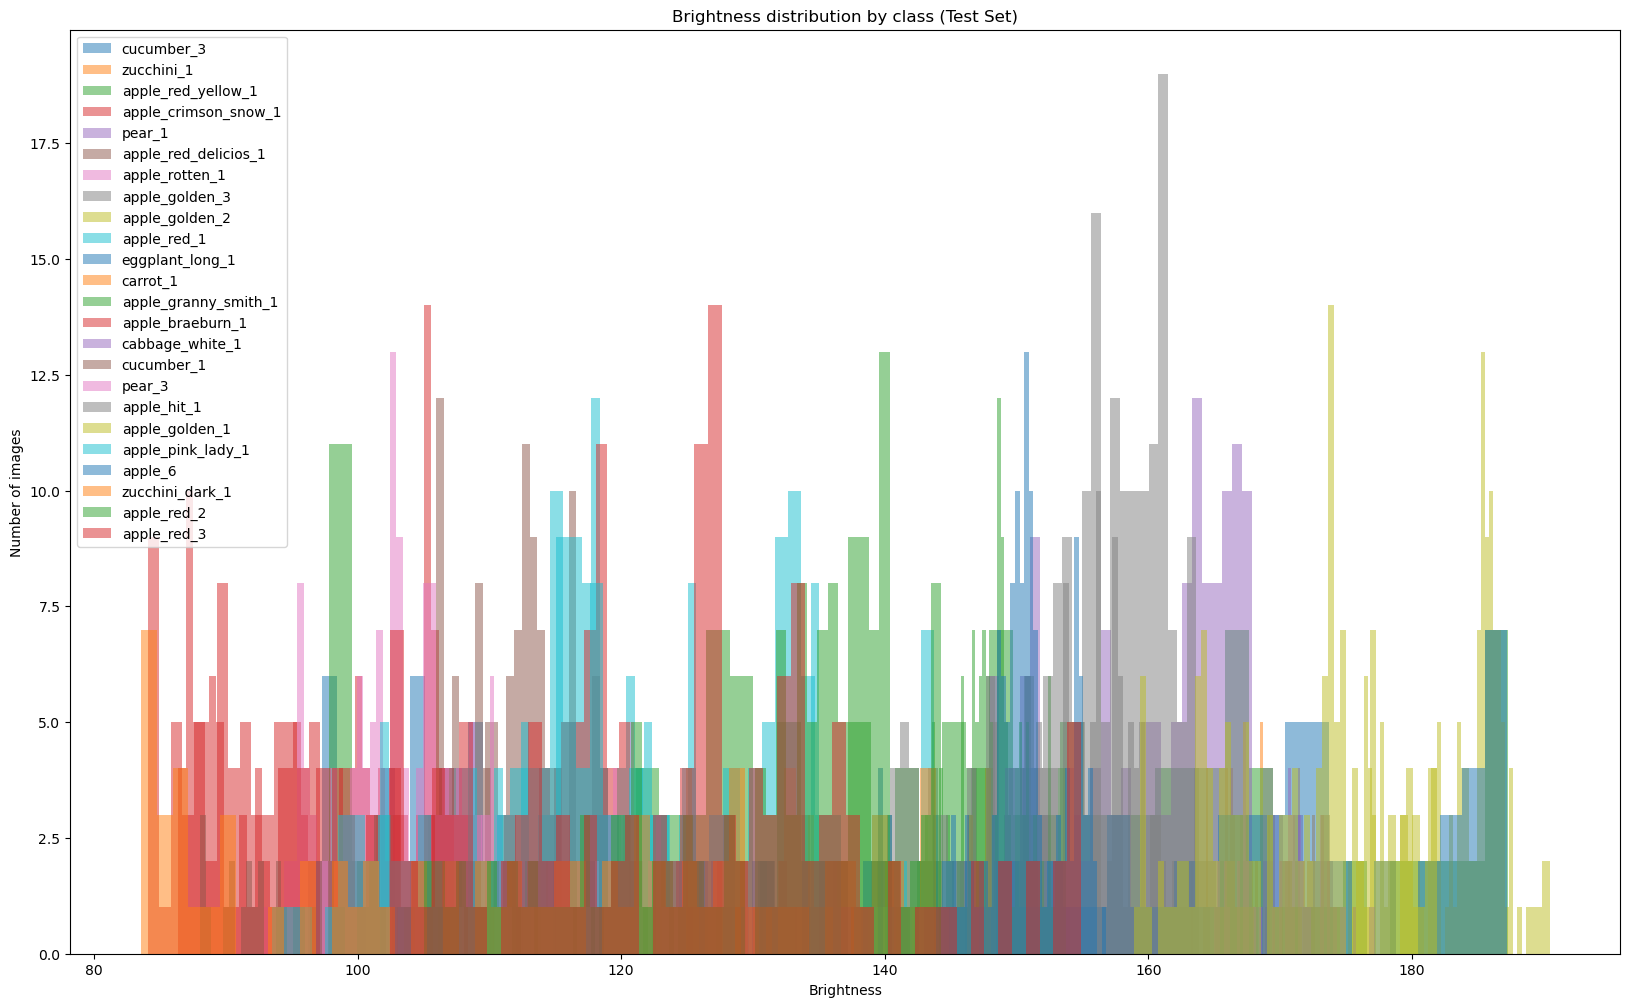

In [113]:
# Example of using a function for a test set
plot_brightness_distribution(df_test, title='Brightness distribution by class (Test Set)')

The presented charts visualize the distribution of image brightness across different classes for the training and test datasets.

- Brightness Distribution in the Training Set: The first chart shows how brightness is distributed across classes in the training set. It is evident that brightness values are spread over a wide range, with each class having its characteristic peaks. This indicates that the images in the training set were taken under varying lighting conditions, which can help train a more robust model.
- Brightness Distribution in the Test Set: The second chart illustrates the brightness distribution in the test set. Overall, the pattern is similar to that of the training set, although the number of images in each class is smaller, which is expected. This similarity suggests that the test set is well-aligned with the training set in terms of brightness diversity.

**Conclusion**

The consistent brightness distributions across the training and test datasets indicate that the data preparation process was executed correctly, maintaining balance and diversity in the images. This should positively impact the model's ability to generalize to new data. The diversity in brightness within each class will help the model learn to recognize classes under different lighting conditions, which is crucial for developing a reliable classifier.

---

Here is an analysis of the presence of deviations in the brightness of images in training, and test data sets.

In [118]:
# Function to calculate image brightness
def calculate_brightness(image):
    return np.mean(image)

# Applying brightness calculation to both training and test sets
df_train['brightness'] = df_train['image_path'].apply(lambda x: calculate_brightness(cv2.imread(x, cv2.IMREAD_GRAYSCALE)))
df_test['brightness'] = df_test['image_path'].apply(lambda x: calculate_brightness(cv2.imread(x, cv2.IMREAD_GRAYSCALE)))

# Outlier detection function
def filter_outliers(df, dataset_name):
    # Calculation of quartiles and interquartile range (IQR)
    Q1 = df['brightness'].quantile(0.25)
    Q3 = df['brightness'].quantile(0.75)
    IQR = Q3 - Q1

    # Determining the outlier limits
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering outliers
    outliers = df[(df['brightness'] < lower_bound) | (df['brightness'] > upper_bound)]

    if outliers.empty:
        print(f"No outliers found in {dataset_name}.")
    else:
        outliers['dataset'] = dataset_name
        print(f"Outliers detected in {dataset_name}:")
        print(outliers[['image_path', 'brightness']])
    
    return outliers

In [119]:
# Apply filtering to both datasets
outliers_train = filter_outliers(df_train, 'Training Set')
outliers_test = filter_outliers(df_test, 'Test Set')

# Combine outliers if needed
all_outliers = pd.concat([outliers_train, outliers_test])

# If any outliers were found, display them
if not all_outliers.empty:
    print("Outliers found:")
    print(all_outliers[['image_path', 'brightness', 'dataset']])
else:
    print("No outliers found in any dataset.")

No outliers found in Training Set.
No outliers found in Test Set.
No outliers found in any dataset.


Visualize the distribution of image brightness across multiple datasets using a box plot

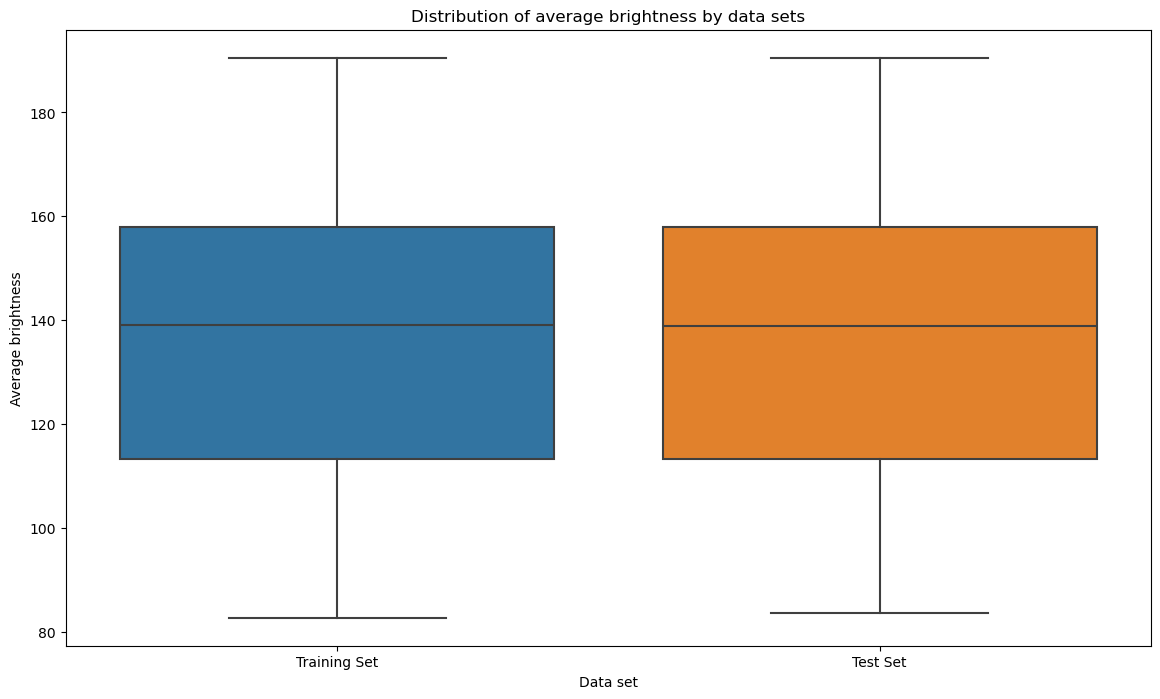

In [120]:
def plot_brightness_boxplot(dfs, labels, title='Distribution of average brightness of images'):
    """
    Function to create a brightness distribution card for several data sets.
    
    :param dfs: DataFrame list with data.
    :param labels: List of labels for each data set.
    :param title: Title of the schedule.
    """
    plt.figure(figsize=(14, 8))
    
    # Preparation of data for the box raft
    brightness_data = []
    for df, label in zip(dfs, labels):
        brightness_data.append(pd.DataFrame({
            'Average brightness': df['brightness'],
            'Data set': label
        }))
    
    # Consolidation of data
    combined_data = pd.concat(brightness_data)
    
    # Building a box plot
    sns.boxplot(x='Data set', y='Average brightness', data=combined_data)
    
    # Plot settings
    plt.title(title)
    plt.xlabel('Data set')
    plt.ylabel('Average brightness')
    plt.show()

# Example of using the function for training, and test sets
plot_brightness_boxplot(
    dfs=[df_train, df_test, df_validation],
    labels=['Training Set', 'Test Set'],
    title='Distribution of average brightness by data sets'
)


Overall, there were **no outliers** detected in any of the datasets. This result indicates that the brightness values in the datasets are well-distributed, without any extreme values that could have adversely affected model training or evaluation. The absence of outliers ensures that the datasets are consistent and balanced in terms of brightness, contributing to the reliability of the model’s performance.

## 4 Scale Thresholding

Threshold scaling is used to convert an image to a binary format (black and white), where each pixel is either white or black. This can be useful for selecting objects or contours.

In the first step, a sample image from the training dataset is examined.

In [123]:
sample_image_path = df_train['image_path'].iloc[200]

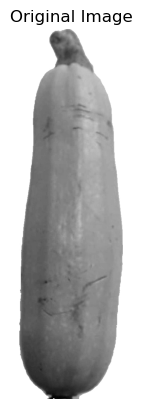

In [124]:
original_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

The image shows that the object is presented with a fairly low contrast, which may explain the difficulties with threshold scaling.

Let's apply Contrast enhancement:

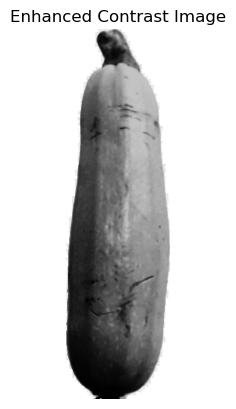

In [125]:
def apply_contrast(image):
    return cv2.equalizeHist(image)

enhanced_image = apply_contrast(original_image)

plt.imshow(enhanced_image, cmap='gray')
plt.title('Enhanced Contrast Image')
plt.axis('off')
plt.show()


After applying contrast enhancement, as seen in the "Enhanced Contrast Image," the object's features become more pronounced, facilitating more accurate subsequent image processing tasks like thresholding.

Let's now apply contrast enhancement, as well as median filtering and two-step blurring, to all images. Let's check the results on several images to make sure that the processing is working correctly.

Step 1: Create a function for full image processing

In [126]:
def process_image(image_path):
    # Step 1: Reading the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 2: Improving contrast using histogram equalization
    enhanced_image = cv2.equalizeHist(image)

    # Defining a helper function to apply median blur with a specified kernel size
    def apply_median_blur(image, kernel_size=5):
        return cv2.medianBlur(image, kernel_size)

    # Applying the first median blur and adaptive thresholding with an increased C value
    blurred_image_1 = apply_median_blur(enhanced_image)
    simple_thresh_image_1 = cv2.adaptiveThreshold(
        blurred_image_1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Applying the second median blur and adaptive thresholding with a reduced C value
    blurred_image_2 = apply_median_blur(simple_thresh_image_1, kernel_size=3)
    simple_thresh_image_2 = cv2.adaptiveThreshold(
        blurred_image_2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1)

    # Returning the processed image after applying the two-step blur and thresholding process
    return simple_thresh_image_2

Step 2: Visualization

In [130]:
def visualize_random_images(df, num_images=5):
    """
    Function for rendering random original and processed images from DataFrame.
    
    :param df: DataFrame containing image paths and processed images
    :param num_images: Number of random images to render (default 5)
    """
    # Choosing random images
    random_indices = random.sample(range(len(df)), num_images)
    random_images = df.iloc[random_indices]

    # Visualization of random processed images
    for index, row in random_images.iterrows():
        plt.figure(figsize=(10, 5))
        
        # Original image
        original_image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # Processed image
        processed_image = row['processed_image']
        plt.subplot(1, 2, 2)
        plt.imshow(processed_image, cmap='gray')
        plt.title('Processed Image')
        plt.axis('off')
        
        plt.show()


Applying processing to all images in the training dataset

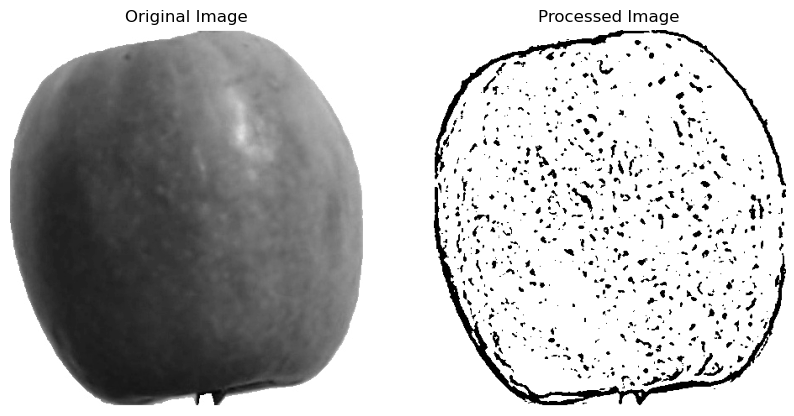

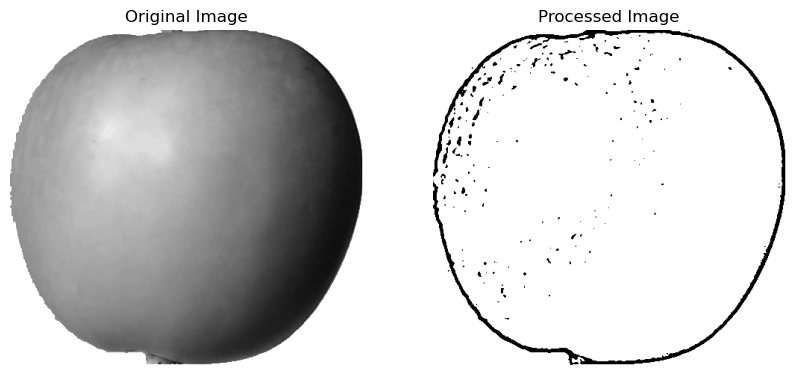

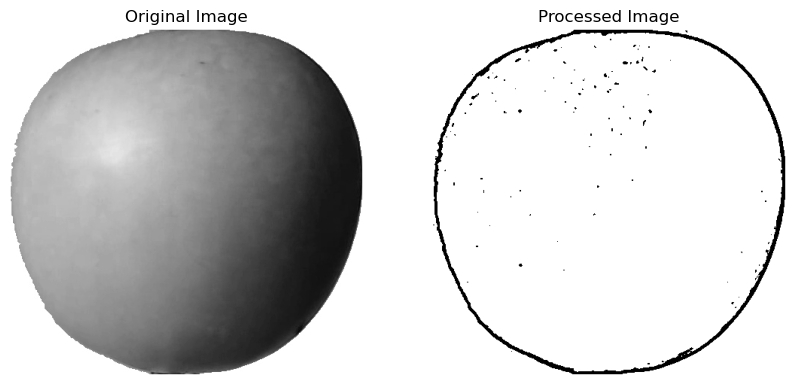

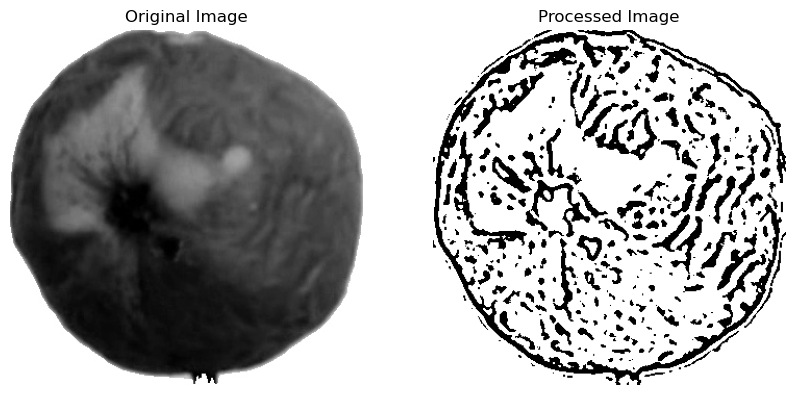

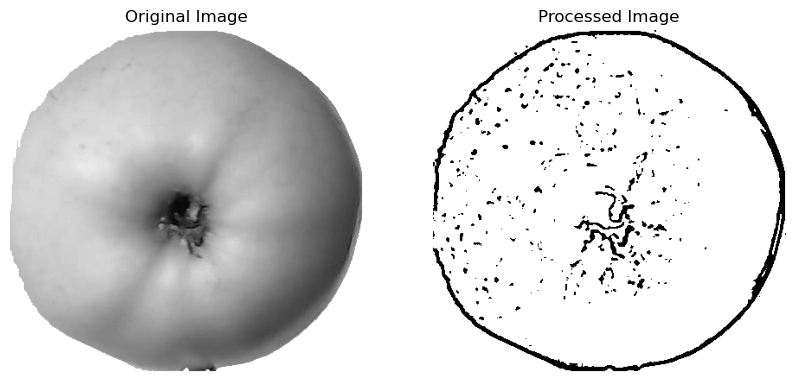

In [131]:
# Applying processing to all images in the training set
df_train['processed_image'] = df_train['image_path'].apply(process_image)
visualize_random_images(df_train)   

Applying processing to all images in the test dataset

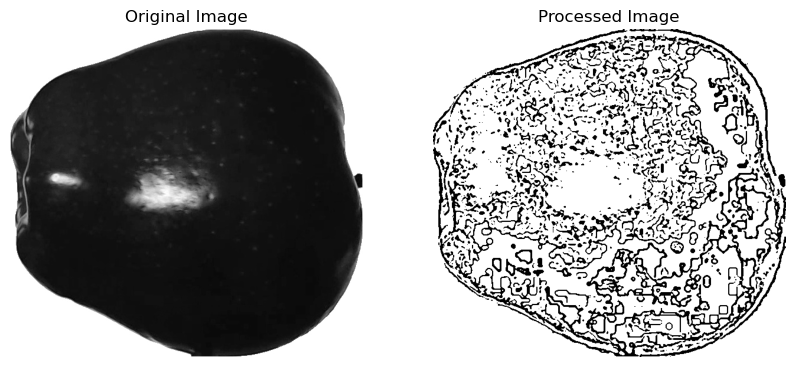

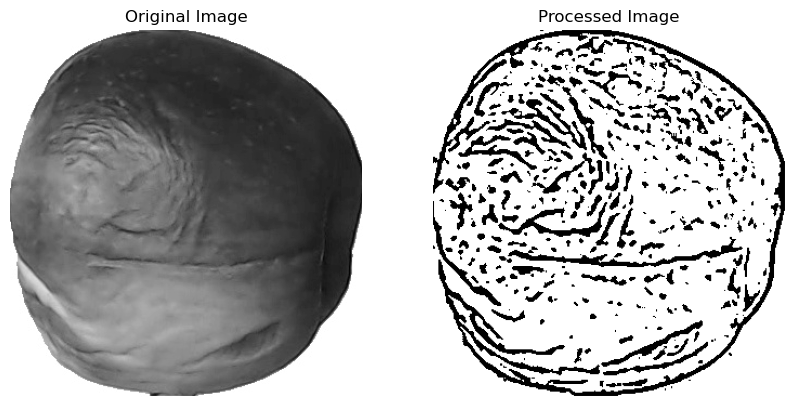

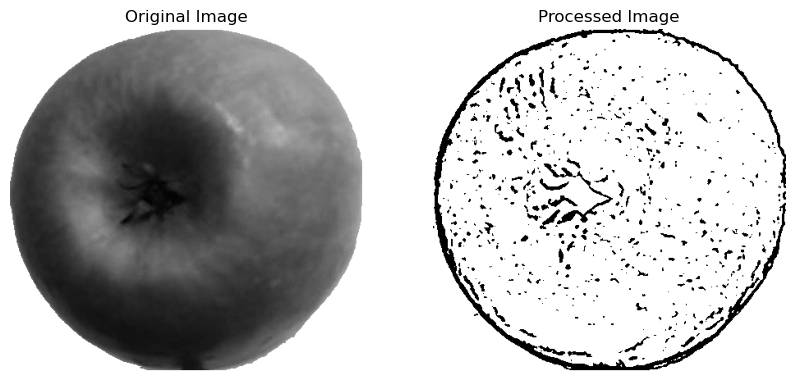

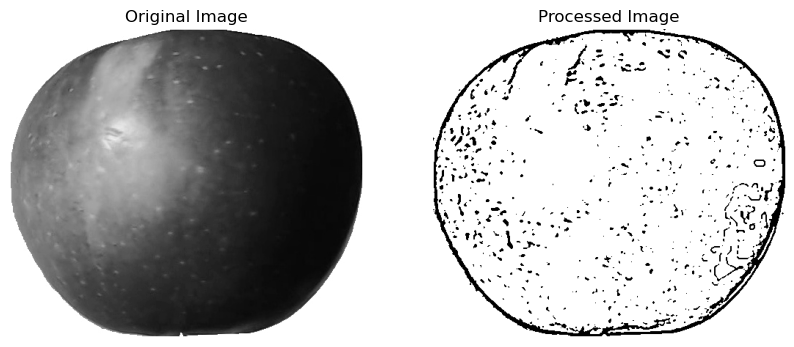

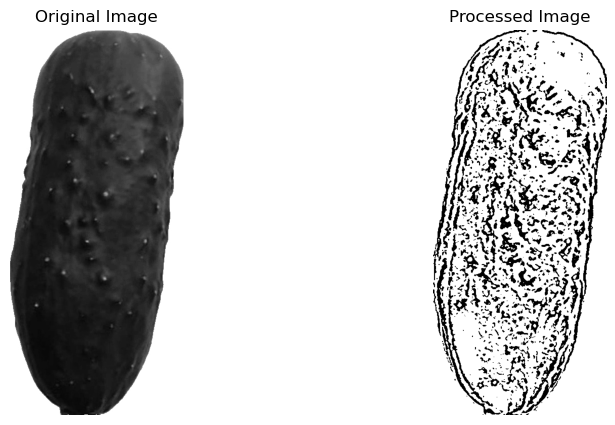

In [132]:
# Applying processing to all images in the test set
df_test['processed_image'] = df_test['image_path'].apply(process_image)
visualize_random_images(df_test)       

## 5  Image Size Analysis and Resizing

In this section, we will analyze the image sizes in the dataset and address any inconsistencies. It's common to have images of varying dimensions within a dataset, especially after various preprocessing steps. These differences in image size can cause issues during model training or analysis, as most machine learning models expect input data of a uniform size.

**Step 1:** Calculating and Displaying Unique Image Sizes

The first step is to calculate the dimensions of each image in the dataset and add this information to the DataFrame. By doing this, we can identify the variety of sizes present and assess the extent of this variability.

In [134]:
# Function for calculating image sizes
def calculate_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape[:2]  # Returns (height, width)

# Function to add image sizes to the DataFrame
def add_image_size_column(df):
    df['image_size'] = df['image_path'].apply(calculate_image_size)
    return df

# Applying the function to add image sizes to the DataFrames
df_train = add_image_size_column(df_train)
df_test = add_image_size_column(df_test)
df_validation = add_image_size_column(df_validation)

In [135]:
def unique_image_sizes_table(df_train, df_test):
    """
    Function to create a table of unique image sizes across training, and test datasets.
    
    :param df_train: DataFrame containing training data
    :param df_test: DataFrame containing test data
    :param df_validation: DataFrame containing validation data
    :return: DataFrame with unique image sizes and their counts for each dataset
    """
    # Count unique image sizes for each dataset
    unique_sizes_train = df_train['image_size'].value_counts().rename('Training')
    unique_sizes_test = df_test['image_size'].value_counts().rename('Test')
    
    # Combine the unique size counts into a single DataFrame
    combined_unique_sizes = pd.concat([unique_sizes_train, unique_sizes_test], axis=1).fillna(0)
    
    # Convert data types for better readability (e.g., to integers)
    combined_unique_sizes = combined_unique_sizes.astype(int)
    
    # Display the table
    display(combined_unique_sizes)

# Now apply the function to display a unique size table
unique_image_sizes_table(df_train, df_test)


,Training,Test
image_size,,
"(348, 349)",15,2
"(316, 350)",14,3
"(347, 350)",14,6
"(526, 413)",12,2
"(318, 344)",11,6
...,...,...
"(403, 464)",0,1
"(398, 436)",0,1
"(407, 463)",0,1


**Step 2:** Resizing Images to a Uniform Size

To ensure consistency and facilitate smooth processing, all images will be resized to a standard size. For this task, a target size of 100x100 pixels is chosen, which is a commonly used dimension for image classification tasks. This size is selected to balance computational efficiency with the retention of important image features.

After resizing, it can be confirmed that all images now conform to the uniform dimensions of 100x100 pixels. This uniformity will help avoid issues related to varying input sizes during the training of machine learning models.

In [137]:
def resize_image(image, target_size=(100, 100)):
    return cv2.resize(image, target_size)

def resize_and_count_unique_sizes(df, target_size=(100, 100)):
    df['processed_image_resized'] = df['processed_image'].apply(lambda img: resize_image(img, target_size))
    df['image_size_resized'] = df['processed_image_resized'].apply(lambda img: img.shape[:2])
    unique_sizes_resized = df['image_size_resized'].value_counts()
    return unique_sizes_resized

# Applying the resizing function to the training, test, and validation datasets
unique_sizes_train = resize_and_count_unique_sizes(df_train)
unique_sizes_test = resize_and_count_unique_sizes(df_test)

# Creating a table with unique image sizes for all three datasets
combined_unique_sizes_resized = pd.concat(
    [unique_sizes_train.rename('Training'), 
     unique_sizes_test.rename('Test')], 
    axis=1
).fillna(0)

# Convert data to integer type for better readability
combined_unique_sizes_resized = combined_unique_sizes_resized.astype(int)

# Print the table of unique image sizes after resizing
print("Unique image sizes after resizing across datasets:")
display(combined_unique_sizes_resized)


Unique image sizes after resizing across datasets:


,Training,Test
image_size_resized,,
"(100, 100)",9345,3110


Finally, a summary of the new image sizes is output to confirm that all images across the training, and test  datasets have been successfully resized to the target dimensions. This consistency is crucial for ensuring that the model can process the data effectively during the training phase.